In [7]:
import os, sys
import json
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer, BertModel
# from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import Dataset_Reader

/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kshitij/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
with open('../data/train.json', 'r') as file:
    train_data = json.load(file)

with open('../data/dev.json', 'r') as file:
    test_data = json.load(file)

In [9]:
TRAIN_data = Dataset_Reader(train_data)
TEST_data = Dataset_Reader(test_data)
print(len(TRAIN_data))
# TRAIN_data_batched = DataLoader(TRAIN_data, batch_size = 5, shuffle= True)

247


In [11]:
def max_length(documents, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
    """
    Generate the maximum length of each sentence in each document. This is necessary to make sure there is a fixed sentence-length 
    for each document before we pass the sentence embeddings through the model.

    Returns: {document index: length of longest sentence}

    """
    max_l_dict = {}
    
    for sentence in documents.texts:
        size = []

        inputs = tokenizer(sentence[2], return_tensors="pt", truncation=True, padding=True, add_special_tokens= True)

        size.append(inputs['input_ids'].size(1))
        
        max_l_dict[sentence[0]] = max(size)
    
    dict_keys = list(max_l_dict.keys())
    reference_keys = list(range(len(documents)))  
    for key in reference_keys:
        if key not in dict_keys:
            max_l_dict[key] = 0
            
    return max_l_dict

In [12]:
def get_batched_data(data: DataLoader, batch_size:int = 5) ->  Tuple[List,List,List]:
    doc_idx = []
    batched_texts = []
    batched_labels = []
    for start, stop in zip(range(0,len(TRAIN_data)-batch_size,batch_size), range(batch_size,len(TRAIN_data),batch_size)):
        idxs = []
        texts = []
        labels = []
        for idx in range(start,stop):
            idxs.append(idx) 
            [texts.append(text) for text in TRAIN_data[idx]['text']]
            [labels.append(label) for label in TRAIN_data[idx]['label']]
        
        doc_idx.append(idxs)
        batched_texts.append(texts)
        batched_labels.append(labels)
    return doc_idx, batched_texts, batched_labels

In [13]:
max_lens_train = max_length(TRAIN_data)

In [15]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TRAIN_data, batch_size= 3)

In [16]:
def label_encode(target_variables : list) -> LabelEncoder:
    """
    Encode target variables.
    
    Args:
    - target_variables (list or array-like): List of target variable strings.
    
    Returns:
    - lb (object): class object used to tranform and inverse transform.
    """
    le = LabelEncoder()
    le = le.fit(target_variables)
    
    return le

def get_model_data(data:torch.utils.data.Dataset, encoder: LabelEncoder,
                   tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                   model= BertModel.from_pretrained('bert-base-uncased'),
                   num_of_docs:int = None,
                   ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(data.labels)
    sent_emb = []
    max_sent_length = 128
    if num_of_docs is None:
        for idx, sentence in enumerate(data.texts):
            inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                padding='max_length', max_length = max_sent_length,
                                add_special_tokens= True)
            with torch.no_grad():
                output = model(**inputs)
            sent_emb.append(output.last_hidden_state[:,0,:])
    else:
        for idx, sentence in enumerate(data.texts):
            if sentence[0] < num_of_docs:
                inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                    padding='max_length', max_length = max_sent_length,
                                    add_special_tokens= True)
                with torch.no_grad():
                    output = model(**inputs)
                sent_emb.append(output.last_hidden_state[:,0,:]) 
        numerical_labels = numerical_labels[:len(sent_emb)]
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train

def get_model_data_batched(indexes:List, texts:List, labels:List, encoder:LabelEncoder,max_len_dict:Dict,
                           tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                           model= BertModel.from_pretrained('bert-base-uncased'),
                           ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(labels)
    sent_emb = []
    for idx, sentence in enumerate(texts):
        try:
            max_sent_length = max([max_len_dict[i] for i in indexes])
        except KeyError:
            continue
        inputs = tokenizer(sentence.lower(),  return_tensors="pt", truncation= True,
                            padding='max_length', max_length = max_sent_length,
                            add_special_tokens= True)
        with torch.no_grad():
            output = model(**inputs)
        sent_emb.append(output.last_hidden_state[:,0,:])
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train    
    

list_of_targets = ['ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED', 'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO']
label_encoder = label_encode(list_of_targets)

In [17]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class BiLSTM(nn.Module):
    def __init__(self,
                input_size:int = 768,
                hidden_size:int = 256,
                num_layers:int = 2,
                output_size:int = 13,
                dropout:float = 0.1
                ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              num_layers = num_layers,
                              bidirectional=True)
        
        self.dense = nn.Sequential(nn.Linear(hidden_size*2, 128),
                                   nn.Dropout(p=dropout),
                                   nn.Linear(128, output_size),
                                   nn.Softmax(dim=1),
        )
        
        self.apply(init_weights)
        
    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out[:, -1, :]

        # # Fully connected layers
        out = self.dense(lstm_out)

        return out

In [54]:
# TRAIN_emb, TRAIN_labels = get_model_data(data= TRAIN_data, encoder= label_encoder, num_of_docs= 10)
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)

X_train size: torch.Size([536, 1, 768])	Y_train size: torch.Size([536])


In [18]:
model = BiLSTM(num_layers=1)
model_opt = torch.optim.Adam(model.parameters(), lr= 0.00005)
loss_function = nn.CrossEntropyLoss()

In [19]:
def train(x_train, y_train, model, optimizer, loss_fc, num_epochs):
    model.train()
    loss_list = []
    acc_list = []
    model.train()
    print(f'{"Starting Training":-^100}')
    for epoch in range(num_epochs+1):
        output = model(x_train)
        loss = loss_fc(output,y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        if epoch%50 == 0:
            acc = sum(output.argmax(dim=1) == y_train)/ output.size(0)
            acc_list.append(acc)
            print(f"Epoch: {epoch} \t Loss: {loss.item():.5f} \t Accuracy: {acc*100:.2f}%")
            
    return loss_list, acc_list
            
def test_accuracy(x_test, y_test, model):
    model.eval()
    output = model(x_test)
    acc = sum(output.argmax(dim=1) == y_test)/ output.size(0)
    print(f"Test Accuracy {acc*100:.2f}%")

In [20]:
# losses, accs = train(TRAIN_emb,TRAIN_labels,model,model_opt,loss_function,300)

In [21]:
# test_accuracy(TEST_emb, TEST_labels, model)

In [37]:
batch_loss, batch_acc = [], []
batch_counter = 0
for idxs, texts, labels in zip(doc_idxs,batched_texts,batched_labels):
    batch_counter += 1
    print(f"{f'BATCH NUMBER {batch_counter}':-^100}")
    TRAIN_emb, TRAIN_labels = get_model_data_batched(idxs,texts,labels,label_encoder,max_lens_train)
    loss, acc = train(TRAIN_emb,TRAIN_labels,model,model_opt,loss_function,150)
    batch_loss.append(loss)
    batch_acc.append(acc)

X_train size: torch.Size([363, 1, 768])
Y_train size: torch.Size([363])
-----------------------------------------Starting Training------------------------------------------
Epoch: 0 	 Loss: 2.57144 	 Accuracy: 3.58%
Epoch: 25 	 Loss: 2.37717 	 Accuracy: 31.13%
Epoch: 50 	 Loss: 2.24312 	 Accuracy: 43.53%
Epoch: 75 	 Loss: 2.12001 	 Accuracy: 56.75%
Epoch: 100 	 Loss: 2.03608 	 Accuracy: 66.39%
Epoch: 125 	 Loss: 2.02191 	 Accuracy: 68.32%
Epoch: 150 	 Loss: 2.01109 	 Accuracy: 68.32%
X_train size: torch.Size([514, 1, 768])
Y_train size: torch.Size([514])
-----------------------------------------Starting Training------------------------------------------
Epoch: 0 	 Loss: 2.20470 	 Accuracy: 47.86%
Epoch: 25 	 Loss: 1.89782 	 Accuracy: 79.96%
Epoch: 50 	 Loss: 1.89474 	 Accuracy: 79.77%
Epoch: 75 	 Loss: 1.89154 	 Accuracy: 80.16%
Epoch: 100 	 Loss: 1.88963 	 Accuracy: 80.35%
Epoch: 125 	 Loss: 1.88675 	 Accuracy: 80.54%
Epoch: 150 	 Loss: 1.88436 	 Accuracy: 80.74%
X_train size: torch.S

KeyError: 69

In [3]:
[[acc.item() for acc in batch] for batch in batch_acc]

NameError: name 'batch_acc' is not defined

In [4]:
batch_acc

NameError: name 'batch_acc' is not defined

In [5]:
len(batch_loss)

NameError: name 'batch_loss' is not defined

# -------------------------------------------------

In [3]:
# def sent2inp(sentence:str, name:str = 'distilbert',max_len:int = 128) -> dict:
#     if name.lower() == 'distilbert':
#         tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case= True)
        
#         model_inputs = tokenizer(sentence.lower(), return_tensors="pt", truncation= True,
#                                 padding='max_length', max_length = max_len, add_special_tokens= True)
            
#         return model_inputs
    
# def label_encode(target_variables : list) -> LabelEncoder:
#     """
#     Encode target variables.
    
#     Args:
#     - target_variables (list or array-like): List of target variable strings.
    
#     Returns:
#     - lb (object): class object used to tranform and inverse transform.
#     """
#     le = LabelEncoder()
#     le = le.fit(target_variables)
    
#     return le

# def get_test_data(num_of_samples: int = 30, label_encoder: LabelEncoder= None) -> Tuple[dict,torch.TensorType]:
#     if label_encoder == None:
#         print("Enter a label encoder")
#         return
#     else:
#         test_sentences = []
#         test_label_enc = torch.Tensor()
#         i = 0
#         while i < 30:
#             doc_num = random.randint(0,len(test_data)-1)
#             file_num = random.randint(0,len(data[doc_num]['annotations'][0]['result'])-1)
#             sentence = data[doc_num]['annotations'][0]['result'][file_num]['value']['text']
#             label = data[doc_num]['annotations'][0]['result'][file_num]['value']['labels']
#             test_sentences.append(sentence)
#             label_encoded = torch.from_numpy(label_encoder.transform(label)).long()
#             # create batch tensors for sentences and labels
#             test_label_enc = torch.cat((test_label_enc, label_encoded),dim=0).long()
#             i += 1
#         test_input = {}
#         test_input['input_ids'] = torch.cat([sent2inp(sentence)['input_ids'] for sentence in test_sentences],dim=0)
#         test_input['attention_mask'] = torch.cat([sent2inp(sentence)['attention_mask'] for sentence in test_sentences],dim=0)
        
#         return test_input, test_label_enc

# def accuracy(test_input:dict, test_label: torch.TensorType, model: object) -> float:
#     model.eval()
#     with torch.no_grad():
#         predictions = model(test_input)
#     hits = sum(predictions.argmax(dim=1) == test_label).item()
            
#     return hits/test_label.size(0)

# Single-Learning

In [99]:
doc_num = random.randint(0,len(data)-1)
file_num = random.randint(0,len(data[doc_num]['annotations'][0]['result'])-1)
sentence = data[doc_num]['annotations'][0]['result'][file_num]['value']['text']
label = data[doc_num]['annotations'][0]['result'][file_num]['value']['labels']
label_encoded = torch.from_numpy(label_encoder.transform(label)).long()
print(f"Doc: {doc_num}, Sentence: {file_num}")
print(f"Sentence: {sentence}\nLabel: {label}, Label-Encoded: {label_encoded}")

Doc: 15, Sentence: 119
Sentence: On careful perusal of this evidence, it can be said that the property dispute is the motive for the accused to assault Shivamma.
Label: ['ANALYSIS'], Label-Encoded: tensor([0])


In [100]:
sent_inp = sent2inp(sentence)
# sent_inp

In [101]:
output = model(sent_inp)

In [109]:
label_encoder.inverse_transform([torch.argmax(output)]).item()

'ARG_PETITIONER'

In [37]:
loss = loss_function(output,label_encoded)

In [38]:
loss

tensor(2.5611, grad_fn=<NllLossBackward0>)

In [39]:
loss.backward()

In [40]:
model_opt.step()

In [41]:
model_opt.zero_grad()

# Batch-Learning

In [68]:
i = 0
sentences = []
labels = []
batch_label_enc = torch.Tensor()
model.train()
while i < 16:
    doc_num = random.randint(0,len(data)-1)
    if len(data[doc_num]['annotations'][0]['result']) != 0:
        file_num = random.randint(0,len(data[doc_num]['annotations'][0]['result'])-1)
        i += 1
    else:
        continue
    # get a random training instance and label from training set
    sentence = data[doc_num]['annotations'][0]['result'][file_num]['value']['text']
    label = data[doc_num]['annotations'][0]['result'][file_num]['value']['labels']
    sentences.append(sentence)
    label_encoded = torch.from_numpy(label_encoder.transform(label)).long()
    # create batch tensors for sentences and labels
    batch_label_enc = torch.cat((batch_label_enc, label_encoded),dim=0).long()
input = {}
input['input_ids'] = torch.cat([sent2inp(sentence)['input_ids'] for sentence in sentences],dim=0)
input['attention_mask'] = torch.cat([sent2inp(sentence)['attention_mask'] for sentence in sentences],dim=0)

In [7]:
# i = 0
# batch_tensor = torch.Tensor()
# batch_label_enc = torch.Tensor()
# model.train()

# while i < 16:
#     doc_num = random.randint(0,len(data)-1)
#     if len(data[doc_num]['annotations'][0]['result']) != 0:
#         file_num = random.randint(0,len(data[doc_num]['annotations'][0]['result'])-1)
#         i += 1
#     else:
#         continue
#     # get a random training instance and label from training set
#     sentence = data[doc_num]['annotations'][0]['result'][file_num]['value']['text']
#     label = data[doc_num]['annotations'][0]['result'][file_num]['value']['labels']
#     # get sentence embedding and encode the label using LabelEncoder class
#     sent_emb = sent2wordemb(sentence)
#     label_encoded = torch.from_numpy(label_encoder.transform(label)).long()
#     # create batch tensors for sentences and labels
#     batch_tensor = torch.cat((batch_tensor,sent_emb),dim=0)
#     batch_label_enc = torch.cat((batch_label_enc, label_encoded),dim=0).long()

In [69]:
output = model(input)

In [70]:
output.size()

torch.Size([16, 13])

In [71]:
loss = loss_function(output, batch_label_enc)
loss

tensor(2.5638, grad_fn=<NllLossBackward0>)

In [72]:
loss.backward()

In [73]:
model_opt.step()

In [74]:
model_opt.zero_grad()

# Training with batch-learning

In [12]:
model = BiLSTM()
model_opt = torch.optim.RMSprop(model.parameters(), lr= 0.00)
loss_function = nn.CrossEntropyLoss()

In [13]:
epoch = 0
loss_list = []
acc_list = []

while epoch < 100:
    i = 0
    sentences = []
    labels = []
    batch_label_enc = torch.Tensor()
    model.train()
    while i < 8:
        doc_num = random.randint(0,len(data)-1)
        if len(data[doc_num]['annotations'][0]['result']) != 0:
            file_num = random.randint(0,len(data[doc_num]['annotations'][0]['result'])-1)
            i += 1
        else:
            continue
        # get a random training instance and label from training set
        sentence = data[doc_num]['annotations'][0]['result'][file_num]['value']['text']
        label = data[doc_num]['annotations'][0]['result'][file_num]['value']['labels']
        sentences.append(sentence)
        label_encoded = torch.from_numpy(label_encoder.transform(label)).long()
        # create batch tensors for labels
        batch_label_enc = torch.cat((batch_label_enc, label_encoded),dim=0).long()
    input = {}
    input['input_ids'] = torch.cat([sent2inp(sentence)['input_ids'] for sentence in sentences],dim=0)
    input['attention_mask'] = torch.cat([sent2inp(sentence)['attention_mask'] for sentence in sentences],dim=0)
    
    model_opt.zero_grad()
    output = model(input)
    loss = loss_function(output,batch_label_enc)
    loss_list.append(loss.item())
    loss.backward()
    model_opt.step()
    
    acc = accuracy(test_inputs, test_labels, model) * 100
    acc_list.append(acc)
    
    epoch += 1
    print(f"{f'Epoch {epoch}':-^50}\nLoss: {loss.item():.5f} Accuracy: {acc:.2f}")
    

---------------------Epoch 1----------------------
Loss: 2.56515 Accuracy: 50.00
---------------------Epoch 2----------------------
Loss: 2.52010 Accuracy: 50.00
---------------------Epoch 3----------------------
Loss: 2.43526 Accuracy: 50.00
---------------------Epoch 4----------------------
Loss: 2.54317 Accuracy: 26.67
---------------------Epoch 5----------------------
Loss: 2.20016 Accuracy: 26.67
---------------------Epoch 6----------------------
Loss: 2.56347 Accuracy: 26.67
---------------------Epoch 7----------------------
Loss: 2.31730 Accuracy: 26.67
---------------------Epoch 8----------------------
Loss: 2.43872 Accuracy: 26.67
---------------------Epoch 9----------------------
Loss: 2.31522 Accuracy: 26.67
---------------------Epoch 10---------------------
Loss: 2.56374 Accuracy: 26.67
---------------------Epoch 11---------------------
Loss: 2.43920 Accuracy: 26.67
---------------------Epoch 12---------------------
Loss: 2.31512 Accuracy: 26.67
---------------------Epoch 1

KeyboardInterrupt: 

<AxesSubplot:>

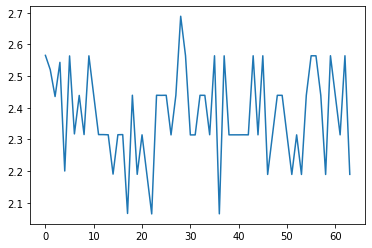

In [14]:
import seaborn as sns

sns.lineplot(x=range(len(loss_list)),y=loss_list)

In [78]:
a = 2e-5